In [84]:
import sys
import os
import scipy
#import scipy.io
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [5]:
# Principal Component Analysis (PCA) by eigenvector decomposition of COV matrix
def get_pca_components(X, k=3):
  # Make X zero mean (could have also done with mean of whole X rather than with mean column)
  X_mean = np.mean(X,axis=1)
  X = X - X_mean.reshape(-1,1)
  assert np.mean(X) <= 1e-7
  # Compute Covariance matrix for X
  COV = np.matmul(X, np.transpose(X))  # a symmetric (thus square) positive semi-definite matrix
  # Eigendecomposition of COV to find (right) eigenvectors
  eig_values, eig_vecs = scipy.sparse.linalg.eigs(COV, k=k) # (columns of) eig_vecs are the P.C vectors
  return eig_values, eig_vecs

In [172]:
# Independent Component Analysis (ICA) with the Infomax algorithm
def get_ica_components(X, k=3, lr = 9e-6):
  # The input data here will be that projected into the first 'k' principal components, since ICA cannot reduce dimensionality of data
  _, eig_vecs = get_pca_components(X, k=k)
  X_projected = eig_vecs.transpose() @ X
  # Initialize W
  W = np.eye(k) # or np.random.randn(k,k)
  # Update step
  Y = W @ X_projected
  for itr in range(500):
    update_matrix = lr * (((Y.shape[1]*np.eye(k,k)) - ((2 * np.tanh(Y)) @ Y.transpose())) @ W)
    if np.abs(np.max(update_matrix)) < 1e-10 and np.abs(np.min(update_matrix)) < 1e-10 :
      print(f"ICA converged at iteration {itr}")
      print(f"max: {np.max(update_matrix)} and min: {np.min(update_matrix)} \n")
      break
    W = W + update_matrix
    Y = W @ X_projected # also update y on getting a new W
    # calculate the synthesis features which are mixed to get the input data
  W_inv = scipy.linalg.inv(W)
  return W, W_inv

In [7]:
# Non-negative Matrix Factorization : X = WH

def perform_nmf (X, k=3):
  # Initialize non-negative W & H
  nmf_W = np.random.randn(X.shape[0], k)
  nmf_H = np.random.randn(k, X.shape[1])

  # For stopping condition:
  X_norm = scipy.linalg.norm(X)

  for itr in range(1,201):
    # Update W
    WH = (nmf_W @ nmf_H)
    for i in range(nmf_W.shape[0]):
      for j in range(nmf_W.shape[1]):
        num_sum = 0

        num_sum = np.sum(X[i] * nmf_H[j] / (WH[i] + 1e-6))
        nmf_W[i][j] = nmf_W[i][j] * num_sum / (np.sum(nmf_H[j,:]) + 1e-6)

    # Update H
    WH = (nmf_W @ nmf_H)
    for j in range(nmf_H.shape[0]):
      for kk in range(nmf_H.shape[1]):
        num_sum = 0

        num_sum = np.sum(X[:, kk] * nmf_W[:,j] / (WH[:, kk] + 1e-6))
        nmf_H[j][kk] = nmf_H[j][kk] * num_sum / (np.sum(nmf_W[:,j]) + 1e-6)

    residual = scipy.linalg.norm(X - (nmf_W @ nmf_H))
    if residual/X_norm < 1e-3 :
      print(f"Converged at iteration: {itr}")
      break
    if itr % 50 == 0:
      print(f"Iteration {itr}, residual: {residual}")
  return nmf_W, nmf_H

In [ ]:
# download & read music file
!gdown --id 1hSA7xULgjxJkSdf2WKXR-vTT8R74ZY94 --output vl1.wav
wav_fname = 'vl1.wav'
wav_samplerate, wav_data = wavfile.read(wav_fname)
wav_data = np.array(wav_data, dtype=float)

#sanity check
print(wav_data, type(wav_data[0])) # audio as numbers
print(wav_samplerate)  # sampling rate
wav_length_time = wav_data.shape[0]/wav_samplerate
print(wav_length_time)  # audio file length in seconds

In [9]:
# Create window
window_size = 1024
hamming_window = np.hamming(window_size)
overlap = window_size * 3/4

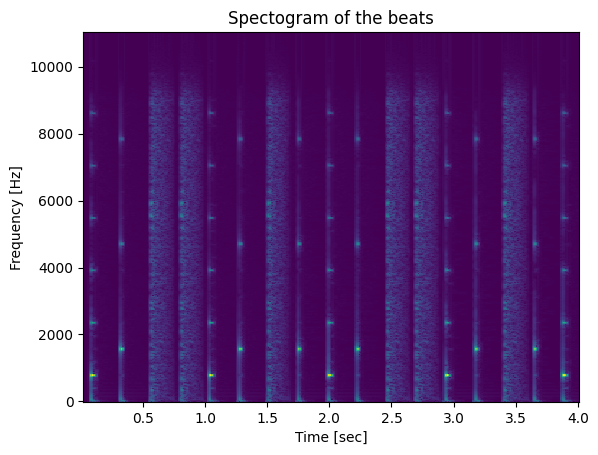

In [154]:
# Compute spectogram using Scipy & visualize using matplotlib
f, t, Sxx = scipy.signal.spectrogram(wav_data, fs=wav_samplerate, window=hamming_window, noverlap=overlap, mode='magnitude')
plt.pcolormesh(t, f, np.sqrt(Sxx), shading='auto')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectogram of the beats')
plt.show()

We can see 3 distinct frequencies (corresponding to the instruments) repeating in time to make the beat

In [ ]:
"""# Compute spectogram manually & visualize using matplotlib
hamming_diag = np.diag(hamming_window)
hamming_dft = np.fft.fft2(hamming_diag)
# use kronecker product bro to compute A
plt.pcolormesh(t, f, Sxx, shading='auto')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()"""

In [12]:
# rows correspond to frequencies & columns correspond to the time segments
print(f.shape, t.shape, Sxx.shape)

(513,) (344,) (513, 344)


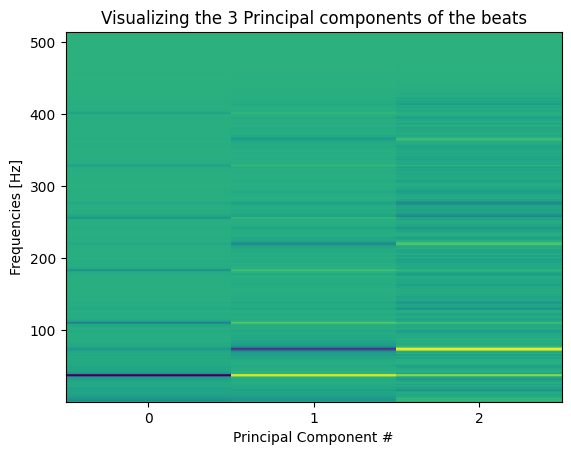

In [155]:
# Treating each time segment in the spectogram representing a vector and the frequencies as dimensions, take PCA. The spectogram magnitudes thus make the 'values' of the vectors
# The first 3 PCA components would be vectors of size:- size(f)

k=3
_, wav_data_eig_vecs = get_pca_components(Sxx, k=k) # (columns of) eig_vecs are the P.C vectors
# shape of eig_vecs will be size(f) * 3

arr_f = np.array([i+1 for i in range(f.shape[0])])  # array of frequencies 1,..,n(f)

# Visualize the first 3 prinicpal components of the data (the first 3 "eigenspectra")
plt.pcolormesh([str(i) for i in range(k)], arr_f, np.real(wav_data_eig_vecs), shading='auto')
plt.ylabel('Frequencies [Hz]')
plt.xlabel('Principal Component #')
plt.title('Visualizing the 3 Principal components of the beats')
plt.show()

In [14]:
print(Sxx.shape, wav_data_eig_vecs.shape)

(513, 344) (513, 3)


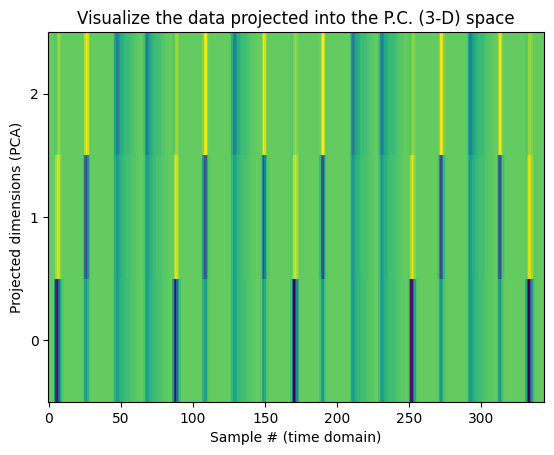

In [159]:
# Project data into the space of the first 3 principal components
Sxx_projected = wav_data_eig_vecs.transpose() @ Sxx
# Visualize the projected data in the P.C. space
plt.pcolormesh([i for i in range(Sxx_projected.shape[1])], [str(i) for i in range(Sxx_projected.shape[0])], np.real(Sxx_projected), shading='auto')
plt.ylabel('Projected dimensions (PCA)')
plt.xlabel('Sample # (time domain)')
plt.title('Visualize the data projected into the P.C. (3-D) space')
plt.show()

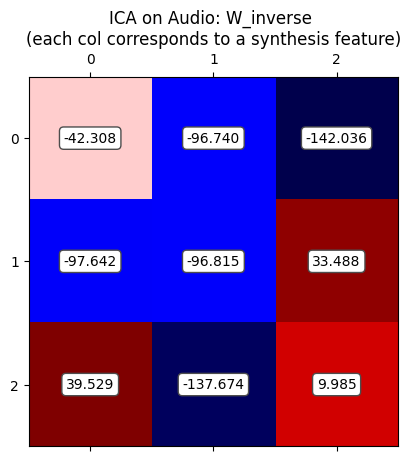

In [183]:
W_wav, W_inv_wav = get_ica_components(Sxx, k=3, lr=1.2e-5)
# Visualize the weights
fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
ax.matshow(np.real(W_inv_wav), cmap='seismic')
for (i, j), z in np.ndenumerate(np.real(W_inv_wav)):
    ax.text(j, i, '{:0.3f}'.format(z), ha='center', va='center', bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
plt.title('ICA on Audio: W_inverse \n(each col corresponds to a synthesis feature)')
plt.show()
# plotting refernce: https://stackoverflow.com/questions/20998083/show-the-values-in-the-grid-using-matplotlib

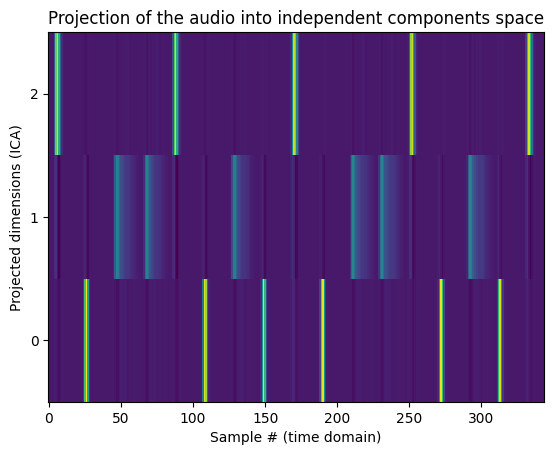

In [184]:
# Compute the ICA projected data (i.e. project data into independent components)
independent_projections = W_wav @ Sxx_projected

# Visualize them
plt.pcolormesh([i for i in range(independent_projections.shape[1])], [str(i) for i in range(k)], np.real(independent_projections), shading='auto')
plt.ylabel('Projected dimensions (ICA)')
plt.xlabel('Sample # (time domain)')
plt.title('Projection of the audio into independent components space')
plt.show()

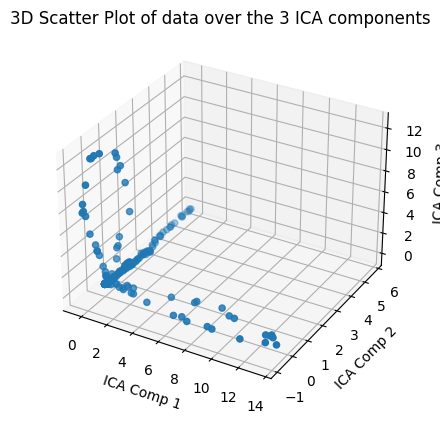

In [186]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

n = independent_projections.shape[1]

#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')

# Extract the three dimensions from your ndarray
x = np.real(independent_projections[0,:])
y = np.real(independent_projections[1,:])
z = np.real(independent_projections[2,:])

# Create the 3D scatter plot
ax.scatter(x, y, z)

# Set labels for each axis
ax.set_xlabel('ICA Comp 1')
ax.set_ylabel('ICA Comp 2')
ax.set_zlabel('ICA Comp 3')

# Optionally, add a title
ax.set_title('3D Scatter Plot of data over the 3 ICA components')

# Show the plot
plt.show()
#adapted from https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html#sphx-glr-gallery-mplot3d-scatter3d-py

ICA is supposed to give us maximally independent components. But if there isn't independence in the data you won't get perfect independence. Varying the laerning rate doesn't make a plot of diff to the plots. Thus can conclude that data is not completely independent - if they were we'd be seeing the points in a more cubic arrangement

In [19]:
wav_W, wav_H = perform_nmf(Sxx, k=3)

Iteration 50, residual: 3504.8110370381614
Iteration 100, residual: 3302.7683170404457
Iteration 150, residual: 3075.9102070110043
Iteration 200, residual: 3081.329626109098


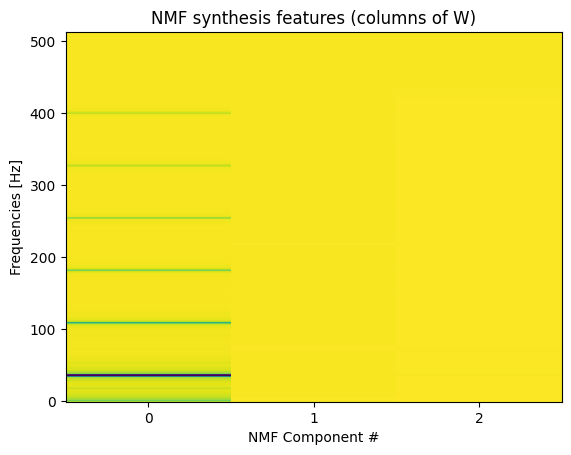

In [175]:
# Visualize the synthesis features from wav_W
plt.pcolormesh([str(i) for i in range(wav_W.shape[1])], [i for i in range(wav_W.shape[0])], wav_W, shading='auto')
plt.ylabel('Frequencies [Hz]')
plt.xlabel('NMF Component #')
plt.title('NMF synthesis features (columns of W)')
plt.show()

First component of NMF looks like a combination of various frequencies (a baseline of sorts), while the second and third seem to be adding different components - as apparent by the change in their color shades

<ipython-input-21-b087a6c1b6b8>:2: RuntimeWarning: invalid value encountered in sqrt
  plt.pcolormesh(t, f, np.sqrt(wav_W @ wav_H), shading='auto')


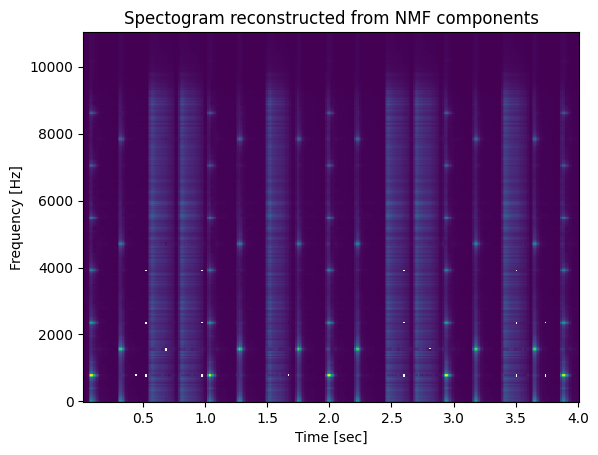

In [21]:
# Visualize reconstruction of spectogram of audio
plt.pcolormesh(t, f, np.sqrt(wav_W @ wav_H), shading='auto')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectogram reconstructed from NMF components')
plt.show()

Reconstructed spectogram looks pretty much like original - wrt separating the frequencies of diff instuments effectively!

In [22]:
!gdown "https://drive.google.com/uc?export=download&id=1rlq3gkxOca9x_cwwGaX_I6EnTXMMjeDF" -O digit-labels.npz

Downloading...
From: https://drive.google.com/uc?export=download&id=1rlq3gkxOca9x_cwwGaX_I6EnTXMMjeDF
To: /content/digit-labels.npz
100% 3.13M/3.13M [00:00<00:00, 86.7MB/s]


(784, 10000) (10000,)
Should be a 7


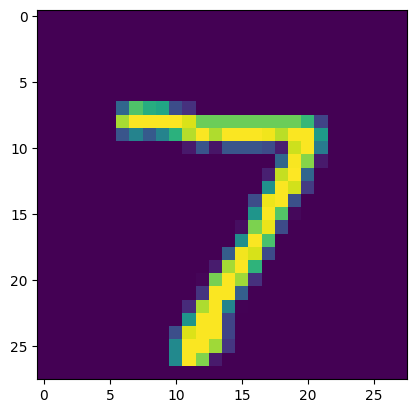

In [23]:
digit_labels = np.load('digit-labels.npz')
images = digit_labels['d']
labels = digit_labels['l']
# sanity check
print(images.shape, labels.shape)
plt.imshow(np.reshape(images[:,0],(28,28),'F'))  # see first image
print(f"Should be a {labels[0]}")

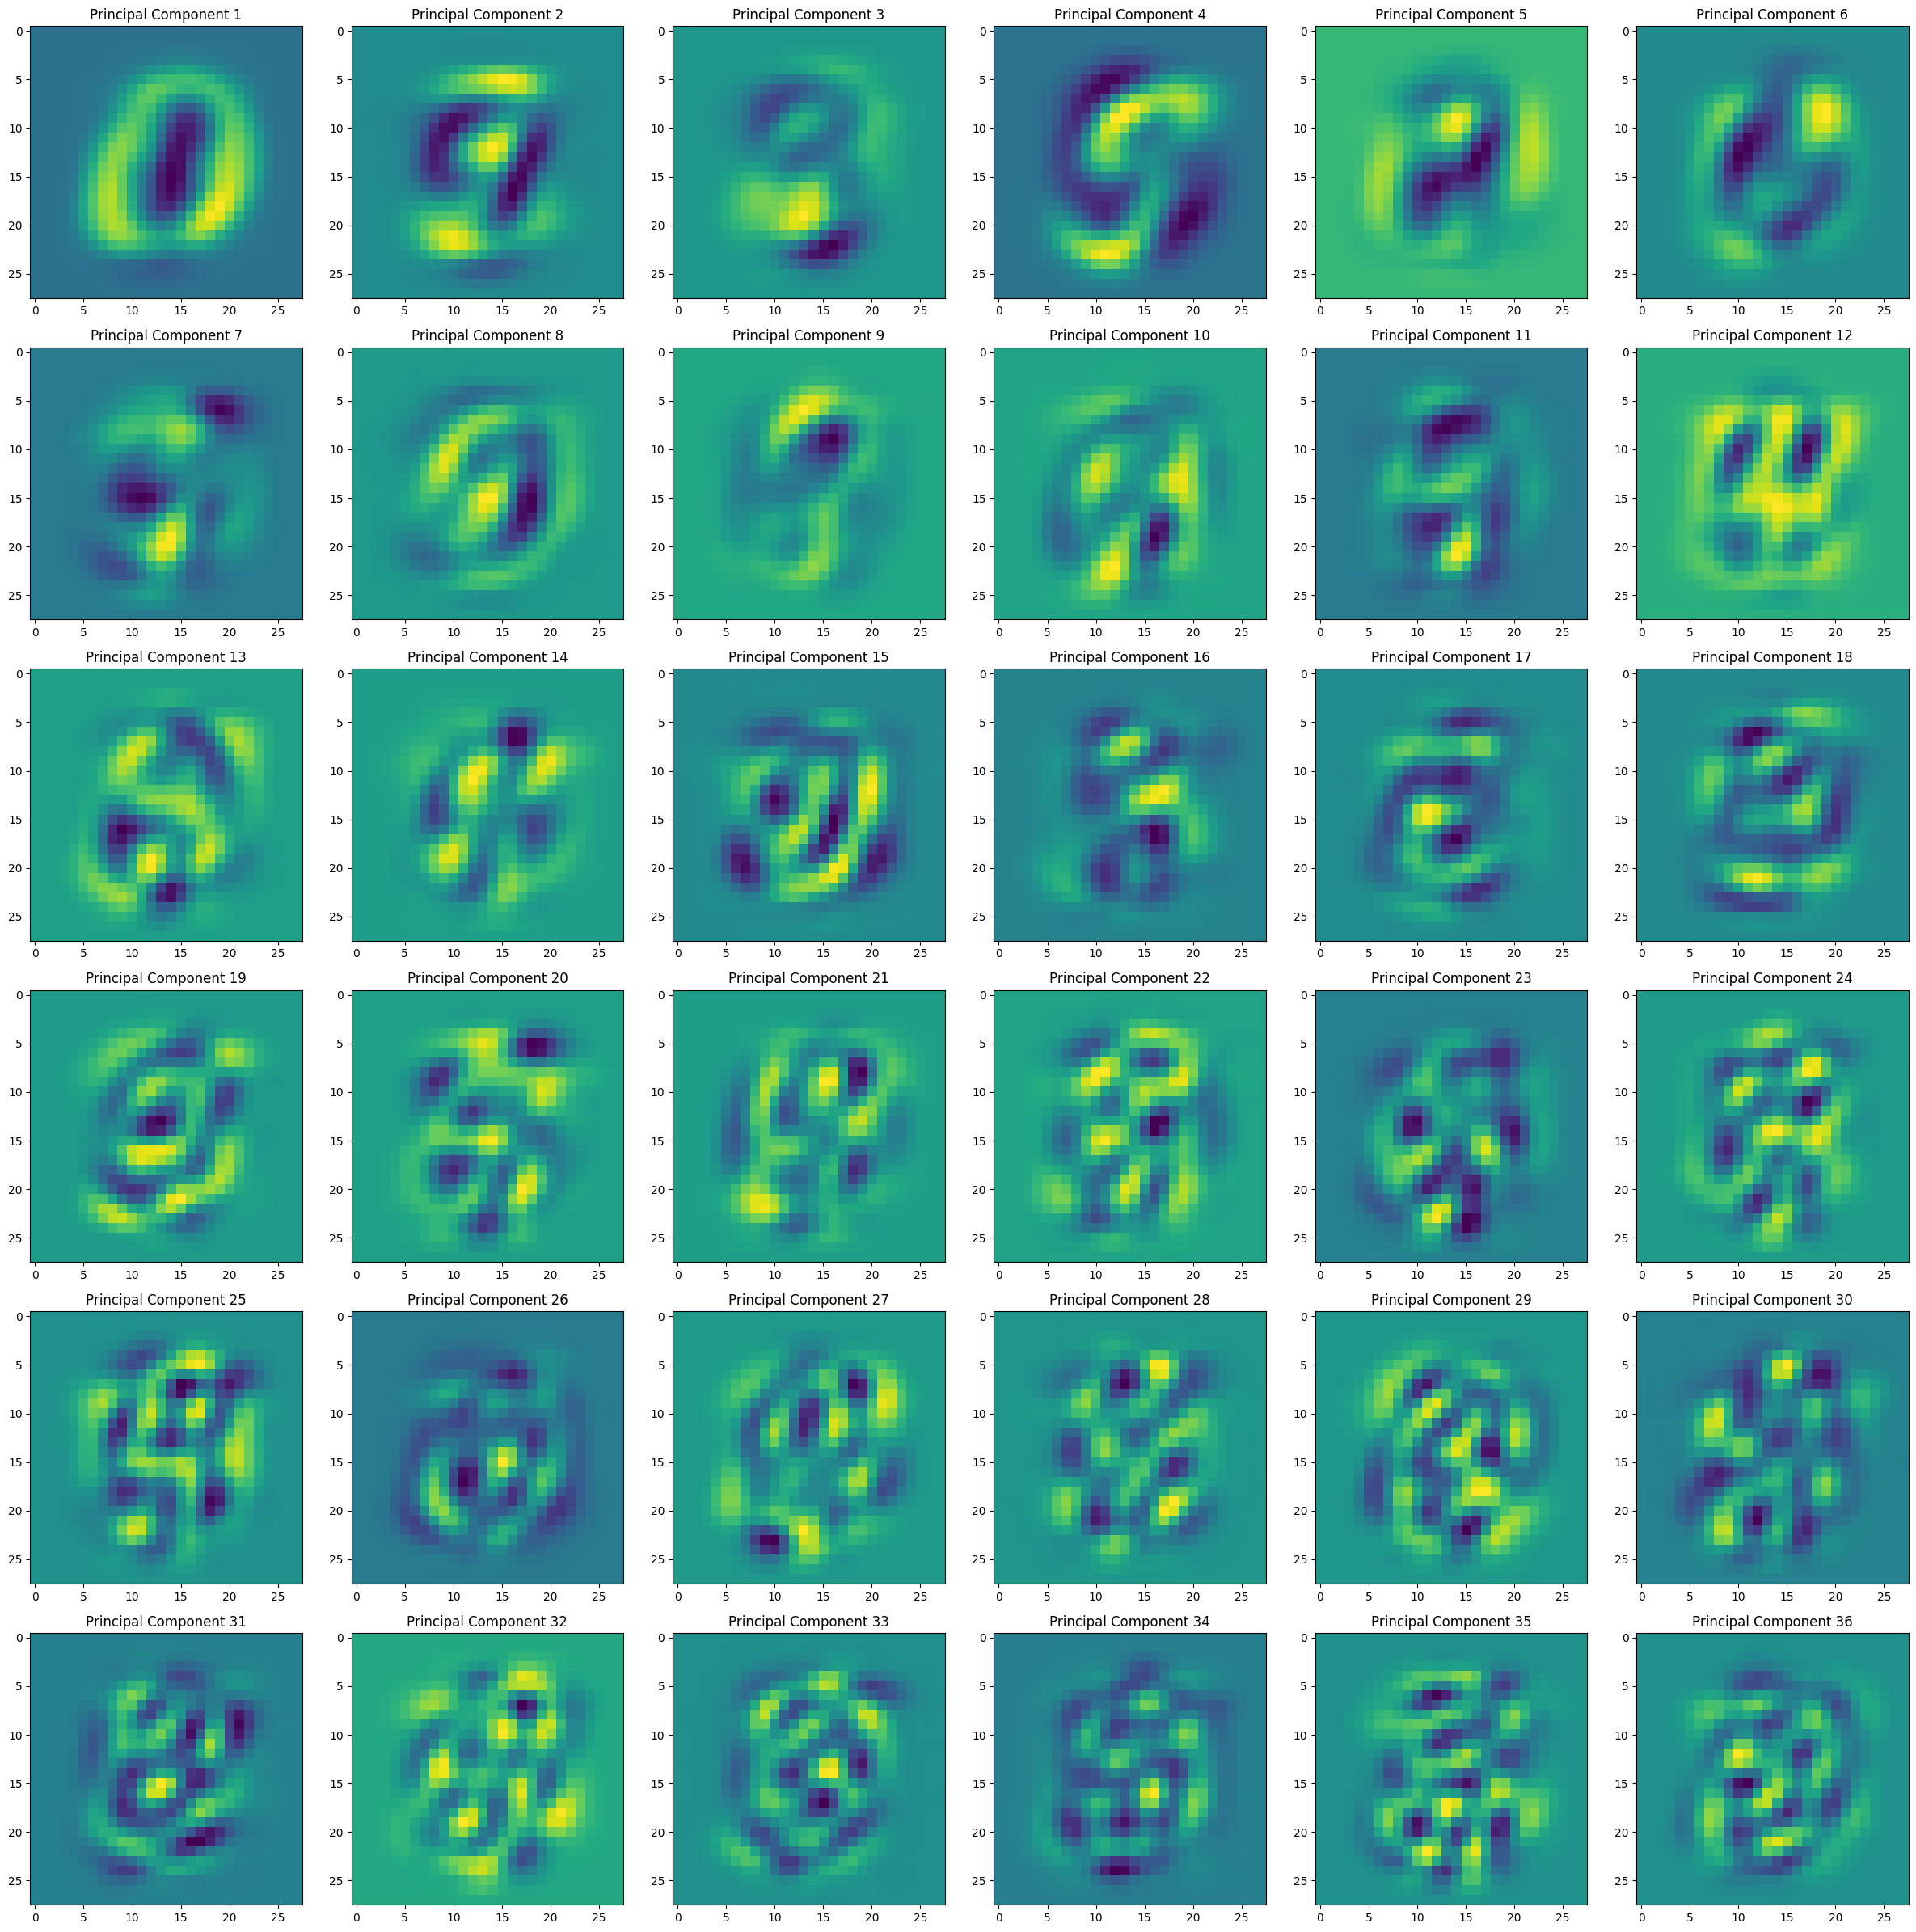

In [24]:
# PCA of images
k=36
_, images_eig_vecs = get_pca_components(images, k=k) # (columns of) eig_vecs are the P.C vectors

# Visualize the first 3 prinicpal components of the data (the first 3 "eigenspectra")
fig, axs = plt.subplots(6,6, figsize=(24, 24))
for idx in range(k):
  component = images_eig_vecs[:,idx]
  row = idx//6
  col = idx %6
  axs[row][col].imshow(np.reshape(np.real(component), (28,28), 'F'))
  axs[row][col].set_title(f'Principal Component {idx+1}')

plt.tight_layout()
plt.show()

PCA components looks like a medley of different shapes making up the numbers - no meaningful disctinction between components

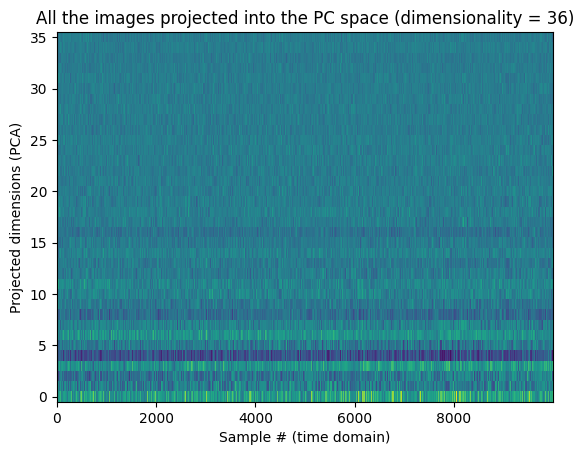

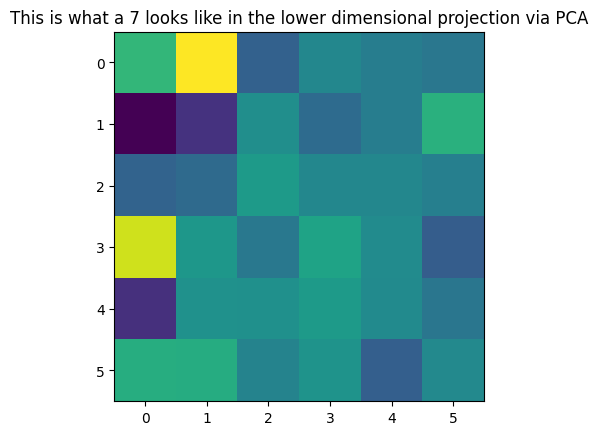

In [25]:
# Project data into the space of the first 3 principal components
images_pca_projected = images_eig_vecs.transpose() @ images
# Visualize the projected data in the P.C. space
plt.pcolormesh([i for i in range(images_pca_projected.shape[1])], [i for i in range(images_pca_projected.shape[0])], np.real(images_pca_projected), shading='auto')
plt.ylabel('Projected dimensions (PCA)')
plt.xlabel('Sample # (time domain)')
plt.title(f'All the images projected into the PC space (dimensionality = {k})')
plt.show()

plt.title(f"This is what a {labels[0]} looks like in the lower dimensional projection via PCA")
plt.imshow(np.reshape(np.real(images_pca_projected[:,0]),(6,6),'F'))  # let's see first image again

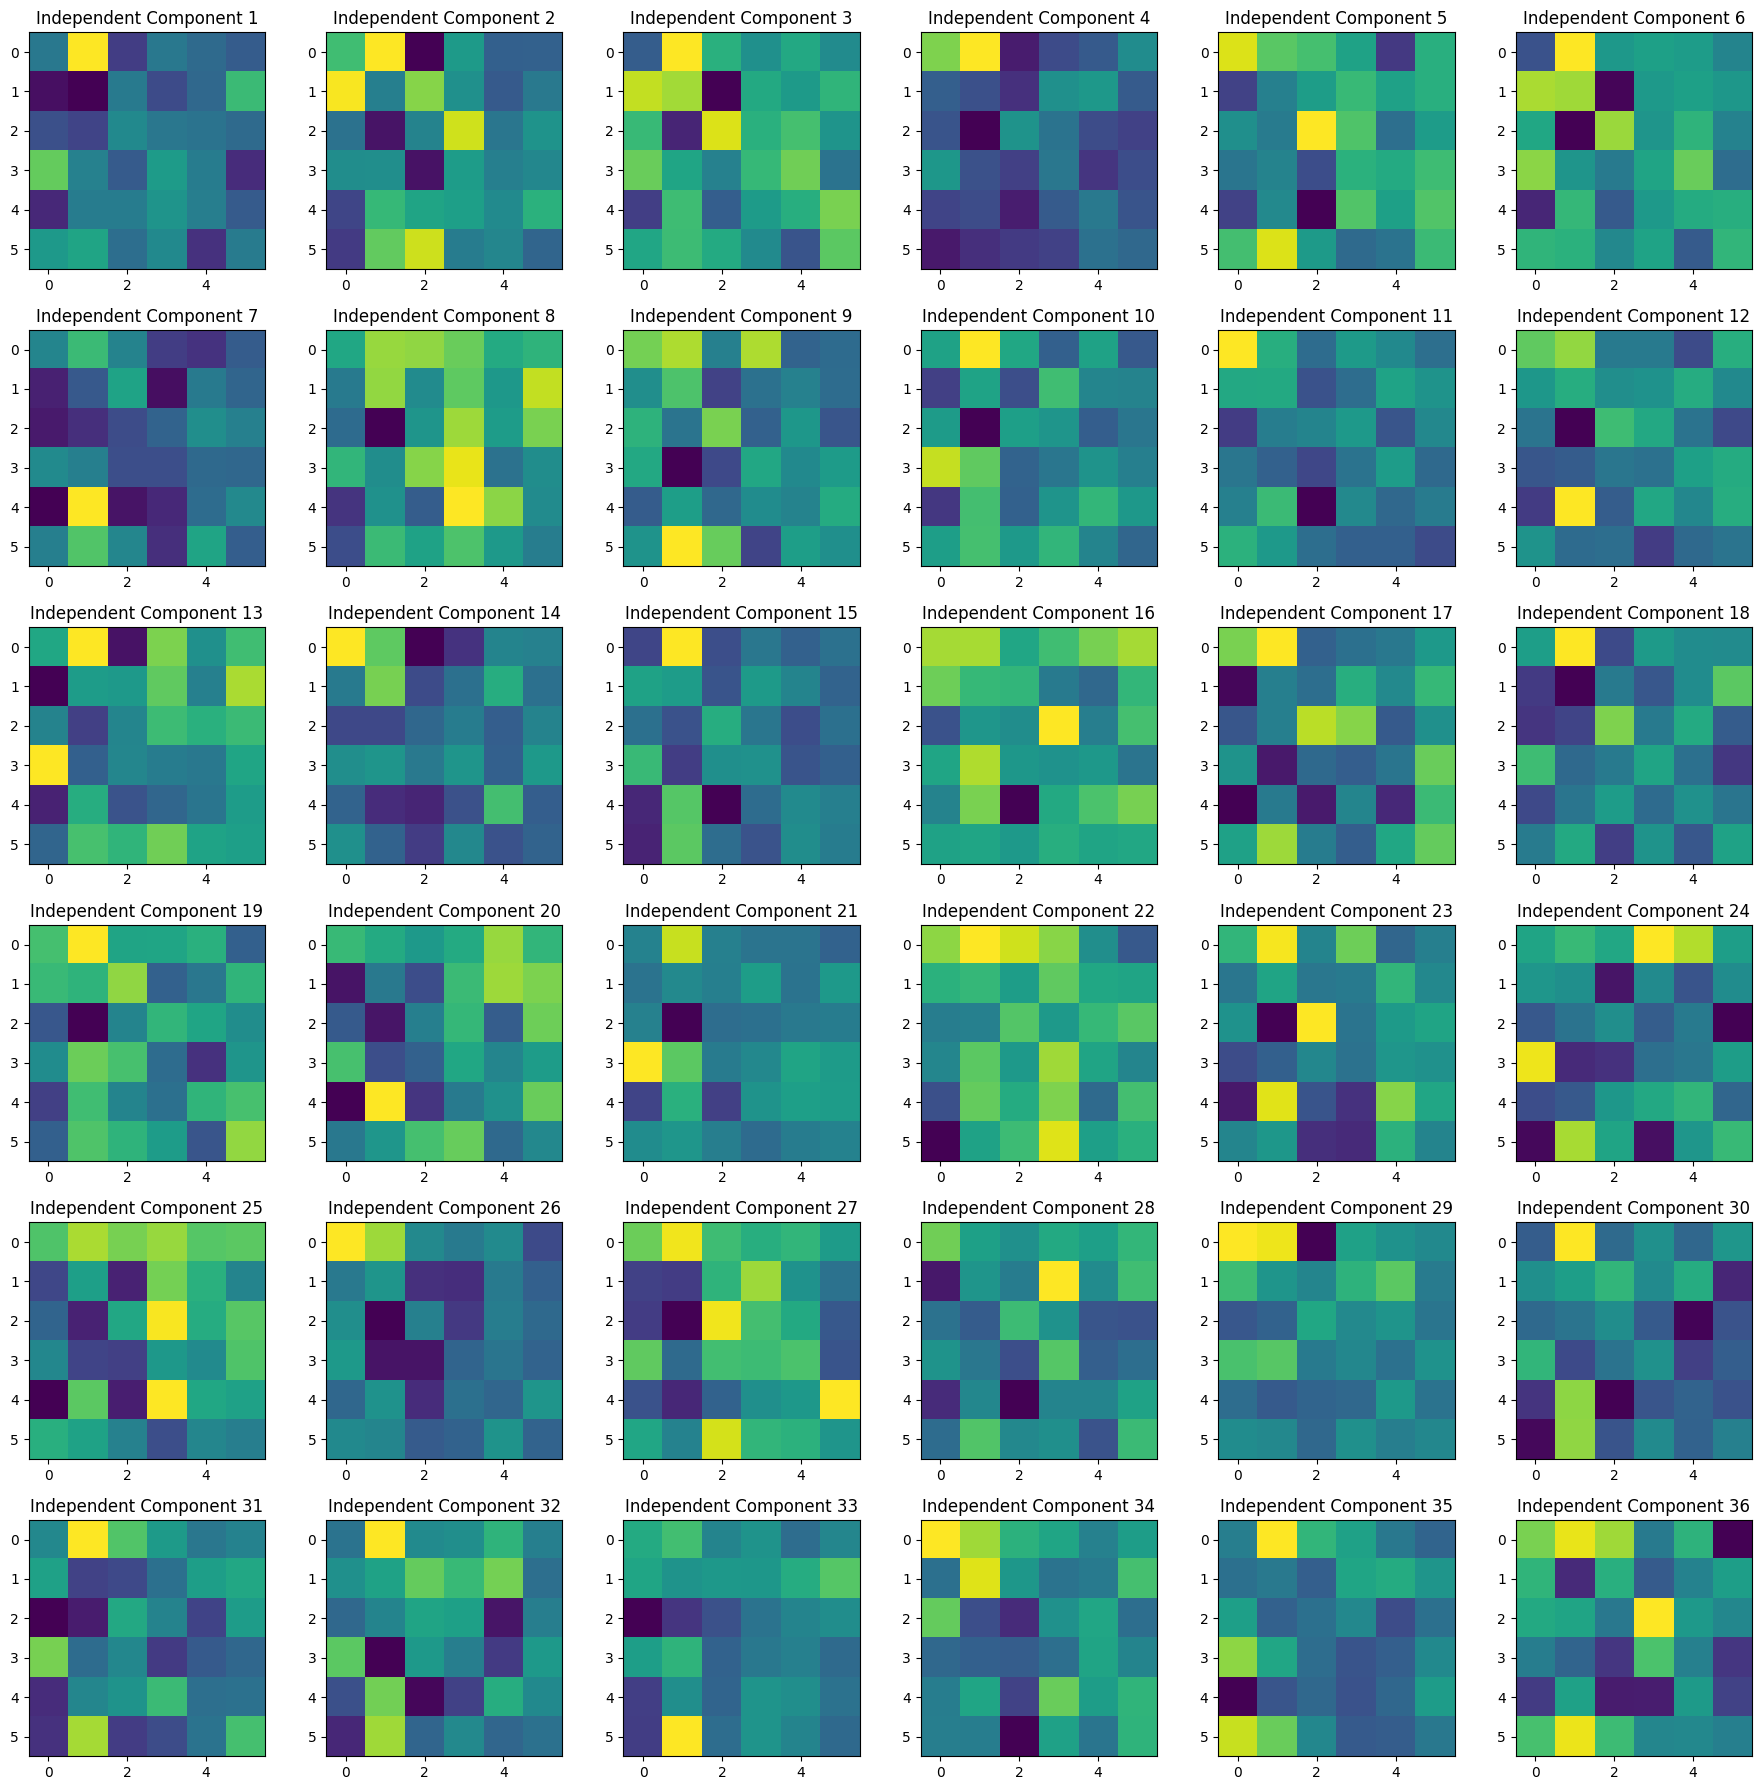

In [26]:
# ICA of images
k=36
W_images, W_inv_images = get_ica_components(images, k=k, lr = 1e-7) # (columns of) eig_vecs are the P.C vectors
images_synthesized_using_ica = W_images @ images_pca_projected

# Visualize the independent components of the data
fig, axs = plt.subplots(6,6, figsize=(18, 18))
for idx in range(k):
  component = images_synthesized_using_ica[:,idx]
  row = idx //6
  col = idx %6
  axs[row][col].imshow(np.reshape(np.real(component), (6,6), 'F'))
  axs[row][col].set_title(f'Independent Component {idx+1}')

plt.tight_layout()
plt.show()

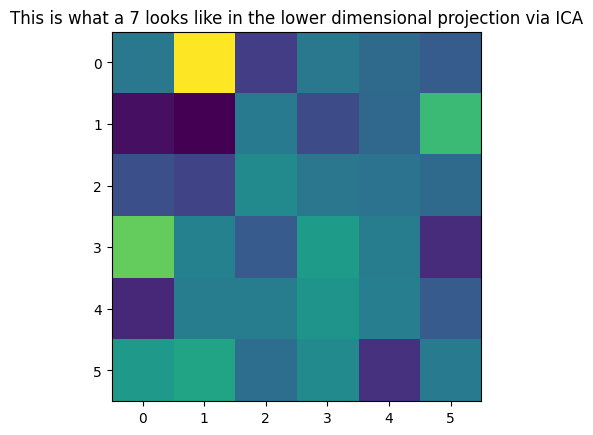

In [27]:
plt.title(f"This is what a {labels[0]} looks like in the lower dimensional projection via ICA")
plt.imshow(np.reshape(np.real(images_synthesized_using_ica[:,0]),(6,6),'F'))  # let's see first image again

In [ ]:
img_W, img_H = perform_nmf(images, k=36)

In [ ]:
images_synthesized_using_nmf = img_W @ img_H

# Visualize the data reconstr. by NMF
fig, axs = plt.subplots(6,6, figsize=(18, 18))
for idx in range(k):
  component = images_synthesized_using_nmf[:,idx]
  row = idx //6
  col = idx %6
  axs[row][col].imshow(np.reshape(np.real(component), (6,6), 'F'))
  axs[row][col].set_title(f'Image {idx+1}')

plt.tight_layout()
plt.show()

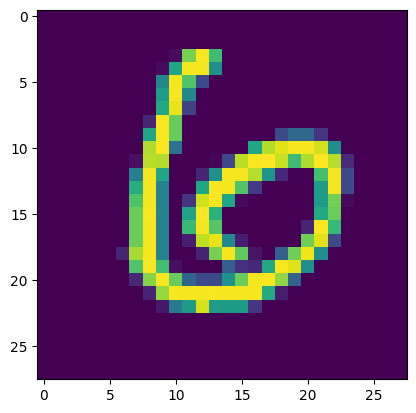

In [28]:
indices_6 = np.where(labels == 6)[0]
only_6 = images[:,indices_6]
# sanity check
plt.imshow(np.reshape(only_6[:,0],(28,28),'F'))

In [29]:
# Perform PCA & drop dimensionality to from 28**2 to 2
k = 2
_, only_6_Wpca = get_pca_components(only_6, k=k)

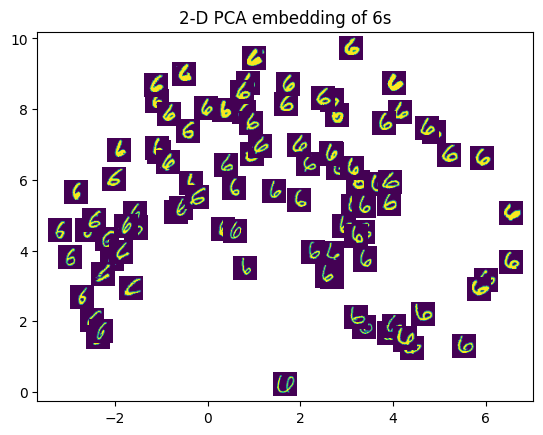

In [73]:
only_6_projected = np.real(only_6_Wpca.T @ only_6)
n_skip = 10
fig, ax = plt.subplots()
x, y = only_6_projected[0,:] , only_6_projected[1,:]
plt.title("2-D PCA embedding of 6s")
ax.scatter(x[::n_skip], y[::n_skip])

idx = 0
for x0, y0 in zip(x, y):
    if idx % n_skip == 0:
      img =  OffsetImage((np.reshape(only_6[:, idx], (28, 28), 'F')), zoom=0.6)
      ab = AnnotationBbox(img, (x0, y0), frameon=False)
      ax.add_artist(ab)
    idx += 1
# plotting code adapted from https://stackoverflow.com/questions/22566284/matplotlib-how-to-plot-images-instead-of-points

We can observe that the 6s with the bigger rounder part at the bottom are towards the right in the image, while the ones where the round part is compressed go to the left
similarly, bolder 6s are up & thinner 6s are below

In [35]:
only_6.shape

(784, 958)

In [146]:
def construct_D_matrix(all_data, n_neighbors=6):
  n_6 = only_6.shape[1]
  D = np.ones((n_6,n_6)) * 1e10 #sys.float_info.max
  for idx in range(n_6):
    data_point = all_data[:,idx]
    dist = [scipy.linalg.norm((data_point - all_data[:,i])) for i in range(only_6.shape[1])]
    k_indices = np.argsort(dist)[1:n_neighbors+1]  # first one will be 0 (dist with itself)
    D[idx][k_indices] = np.array(dist)[k_indices]  # indexing with array
    #D[k_indices][idx] = np.array(dist)[k_indices]  # dist symmetry
  return D

In [147]:
D = construct_D_matrix(only_6)
np.fill_diagonal(D, 0, wrap=False) # dist of point with itself needs to be zeroed out

In [148]:
def do_MDS(D, k=2):
  N = D.shape[0]
  S = - 0.5 * ( D - D @ np.ones_like(D)/N - np.ones_like(D) @ D /N + np.ones_like(D)@D@np.ones_like(D)/(N*N) )
  S_eig_values, S_eig_vecs = scipy.sparse.linalg.eigs(S, k=k)
  X = np.sqrt(S_eig_values).transpose().reshape(-1,1) * S_eig_vecs.transpose()
  return X

In [ ]:
#X_only_6_after_mds = do_MDS(construct_D_matrix(only_6))

In [91]:
#X_only_6_after_mds.shape

(2, 958)

In [149]:
def floyd_warshall_spp(dist):
    n = len(dist)

    shortest_paths = np.copy(dist) # use np.copy for separate copies in memory

    for i in range(n):
        # Update shortest_paths matrix using matrix multiplication
        shortest_paths = np.minimum(shortest_paths, shortest_paths[:, i][:, np.newaxis] + shortest_paths[i, :])

    return shortest_paths

In [150]:
pairwise_shortest_paths = floyd_warshall_spp(D)  # these will also serve as our geodesic distances
#np.fill_diagonal(pairwise_shortest_paths, 0, wrap=False) # dist of point with itself needs to be zeroed out

In [151]:
X_only_6_isomap = do_MDS(pairwise_shortest_paths)

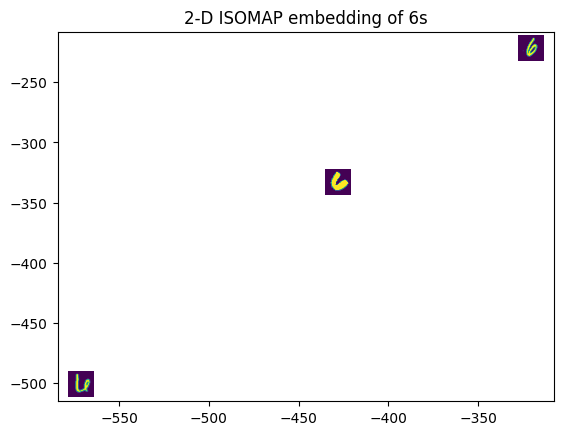

In [152]:
n_subset = 20
fig, ax = plt.subplots()
x, y = X_only_6_isomap[0,:] , X_only_6_isomap[1,:]
plt.title("2-D ISOMAP embedding of 6s")
ax.scatter(x[::n_subset], y[::n_subset])

idx = 0
for x0, y0 in zip(x, y):
    if idx % n_subset == 0:
      img =  OffsetImage((np.reshape(only_6[:, idx], (28, 28), 'F')), zoom=0.65)
      ab = AnnotationBbox(img, (x0, y0), frameon=False)
      ax.add_artist(ab)
    idx += 1